# Demo for ranking protein-protein interfaces using Graph Convolution

## Project setup

In [ ]:
# Copying data and code from GitHub repository
!git clone https://github.com/withai/Demo-Ranking-protein-protein-interfaces-using-GNN.git
!mv Demo-Ranking-protein-protein-interfaces-using-GNN/* .
!rm -r Demo-Ranking-protein-protein-interfaces-using-GNN

## Import libraries

In [1]:
# Import PyTorch
import torch
import torch.backends.cudnn as cudnn
from torch.utils import data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.init as init

# Import Neural Network layer
from nn import Dense

# Import utility functions
from dataset import Dataset
from sampler import CustomSampler
from train import train
from test import test

# Import libraries for graphing
import pandas as pd
import numpy as np
from graph import show_results
import matplotlib.pyplot as plt
%matplotlib inline



## Run computation on GPU or CPU

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Define Graph Convolution layer

$$
h^{(l)}_i = \sigma \left(\mathbf{W}^{(l)}_c h^{(l-1)}_i +
    \frac{1}{|N_i^{(int)}|}\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij} \right.  \left. + \frac{1}{|N_i^{(prot)}|}\sum_{j \epsilon N_i^{(prot)}} \mathbf{W}^{(l)}_{prot} h^{(l-1)}_j \bigodot E_{ij} + b^{(l)} \vphantom{\frac{1}{|N_i^{(neigh)}|}}\right)
$$


where for the layer $l$,  

$\mathbf{W}^{(l)}_c$ is the weight matrix for learning representations w.r.t central node,

$\mathbf{W}^{(l)}_{int}$ and $\mathbf{W}^{(l)}_{prot}$ are the weight matrix for learning representations w.r.t the neighbor nodes in the interface graph and the protein graph respectively,

$b^{(l)}$ is the bias vector, 

$h^{(l)}_i$ is the hidden node embedding of node $i$,

$N_i^{(int)}$ is the number of atoms surrounding node $i$ in the interface graph, 

$N_i^{(prot)}$ is the number of atoms surrounding node $i$ in the protein graph, 

$\sigma$  is the activation function, and

$E_{ij}$ is the value in the edge matrix between node $i$ and node $j$.

### How does computing neighborhood signals look like in the code?

Let's compute neighborhood signals in the interface graph

$
\begin{align}
\frac{1}{|N_i^{(int)}|}\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij} 
\end{align}
$

**Define all the variables**

In [3]:
# node features: One-hot encoding of 11 different atom types
node_feat = torch.tensor([
                            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # atom 1
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # atom 2
                            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], # atom 3
                            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # atom 4 
                        ]).type(torch.float)

# indices of neighbor atoms in interface graph
int_indices = torch.tensor([
                            [1, 2, -1],  # neighbors of atom 1
                            [0, -1, -1], # neighbors of atom 2
                            [1, -1, -1], # neighbors of atom 3
                            [-1, -1, -1] # neighbors of atom 4
                          ])

# edge weights of neighbor atoms in interface graph
int_edges = torch.tensor([
                            [0.9, 0.2, -1], # weights of neighbors of atom 1
                            [0.1, -1, -1],  # weights of neighbors of atom 2
                            [0.5, -1, -1],  # weights of neighbors of atom 3
                            [-1, -1, -1]    # weights of neighbors of atom 4
                        ])

# weight matrix
num_of_features = 11
filters = 16

w_int = torch.randn(num_of_features, filters)


**Step 1: Compute signals for all the nodes in the graph**

In [4]:
node_Wn_int = torch.matmul(node_feat, w_int)

print(node_Wn_int.shape)
print(node_Wn_int)

torch.Size([4, 16])
tensor([[-0.3941, -1.2574, -0.6091,  1.0736, -0.9058, -1.7475,  0.9353, -0.2424,
          0.6113,  0.5230,  0.2550, -0.2047, -1.3506,  0.5298, -0.4015,  0.0150],
        [ 1.6465,  0.4131,  0.0321,  0.8855, -0.2912,  0.7838, -0.4488, -1.3473,
         -1.0906,  1.0139,  0.4203,  0.1642,  1.2011, -0.7894,  0.6780,  0.8977],
        [-0.9270, -0.7774, -1.2629,  1.7078,  0.5497,  1.8573, -0.0765,  0.0360,
          2.3269, -2.7075, -1.7738,  0.1427, -0.0294, -0.2745,  0.2629, -0.5668],
        [ 0.0925,  0.8056, -0.4443,  0.7264, -0.4592, -0.4714, -0.8235,  0.0877,
          0.3983,  0.3654,  1.1938, -0.9651, -0.7113,  0.4504,  0.0540,  1.1967]])


**Step 2: Find all the neighbors of atoms that are participating in the interface graph**

In [5]:
int_part = torch.unsqueeze(int_indices > -1, 2).type(torch.float)

print(int_part.shape)
print(int_part)

torch.Size([4, 3, 1])
tensor([[[1.],
         [1.],
         [0.]],

        [[1.],
         [0.],
         [0.]],

        [[1.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]]])


**Step 3: For each atom find the number of neighbors participating in the graph**

In [6]:
no_of_neighs_int = torch.sum(int_indices > -1, 1).unsqueeze(1)

print(no_of_neighs_int.shape)
print(no_of_neighs_int)

torch.Size([4, 1])
tensor([[2],
        [1],
        [1],
        [0]])


**Step 4a: Make sure we don't divide by zeros**

In [7]:
no_of_neighs_int[no_of_neighs_int == 0] = 1

print(no_of_neighs_int.shape)
print(no_of_neighs_int)

torch.Size([4, 1])
tensor([[2],
        [1],
        [1],
        [1]])


**Step 4b: Expand the dimension of edge weights to allow scalar multiplication**

In [8]:
int_edges = torch.unsqueeze(int_edges, 2)

print(int_edges.shape)
print(int_edges)

torch.Size([4, 3, 1])
tensor([[[ 0.9000],
         [ 0.2000],
         [-1.0000]],

        [[ 0.1000],
         [-1.0000],
         [-1.0000]],

        [[ 0.5000],
         [-1.0000],
         [-1.0000]],

        [[-1.0000],
         [-1.0000],
         [-1.0000]]])


**Step 5: Compute neighbor signals of all the nodes in the interface graph**

Step 5a: Grab all the neighbors of interface atoms

In [9]:
Zn_inter_step = node_Wn_int[int_indices]

print(Zn_inter_step.shape)
print(Zn_inter_step)

torch.Size([4, 3, 16])
tensor([[[ 1.6465,  0.4131,  0.0321,  0.8855, -0.2912,  0.7838, -0.4488,
          -1.3473, -1.0906,  1.0139,  0.4203,  0.1642,  1.2011, -0.7894,
           0.6780,  0.8977],
         [-0.9270, -0.7774, -1.2629,  1.7078,  0.5497,  1.8573, -0.0765,
           0.0360,  2.3269, -2.7075, -1.7738,  0.1427, -0.0294, -0.2745,
           0.2629, -0.5668],
         [ 0.0925,  0.8056, -0.4443,  0.7264, -0.4592, -0.4714, -0.8235,
           0.0877,  0.3983,  0.3654,  1.1938, -0.9651, -0.7113,  0.4504,
           0.0540,  1.1967]],

        [[-0.3941, -1.2574, -0.6091,  1.0736, -0.9058, -1.7475,  0.9353,
          -0.2424,  0.6113,  0.5230,  0.2550, -0.2047, -1.3506,  0.5298,
          -0.4015,  0.0150],
         [ 0.0925,  0.8056, -0.4443,  0.7264, -0.4592, -0.4714, -0.8235,
           0.0877,  0.3983,  0.3654,  1.1938, -0.9651, -0.7113,  0.4504,
           0.0540,  1.1967],
         [ 0.0925,  0.8056, -0.4443,  0.7264, -0.4592, -0.4714, -0.8235,
           0.0877,  0.3983,

Step 5b: Select all the participating neighbors

In [10]:
Zn_inter_step = node_Wn_int[int_indices] * int_part

print(Zn_inter_step.shape)
print(Zn_inter_step)

torch.Size([4, 3, 16])
tensor([[[ 1.6465,  0.4131,  0.0321,  0.8855, -0.2912,  0.7838, -0.4488,
          -1.3473, -1.0906,  1.0139,  0.4203,  0.1642,  1.2011, -0.7894,
           0.6780,  0.8977],
         [-0.9270, -0.7774, -1.2629,  1.7078,  0.5497,  1.8573, -0.0765,
           0.0360,  2.3269, -2.7075, -1.7738,  0.1427, -0.0294, -0.2745,
           0.2629, -0.5668],
         [ 0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
           0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
           0.0000,  0.0000]],

        [[-0.3941, -1.2574, -0.6091,  1.0736, -0.9058, -1.7475,  0.9353,
          -0.2424,  0.6113,  0.5230,  0.2550, -0.2047, -1.3506,  0.5298,
          -0.4015,  0.0150],
         [ 0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
           0.0000,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000,
           0.0000,  0.0000],
         [ 0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,
           0.0000,  0.0000,

Step 5c: Scale each of the participating neighbor by its edge weight

$\mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij}$

In [11]:
Zn_inter_step = node_Wn_int[int_indices] * int_part * int_edges

print(Zn_inter_step.shape)
print(Zn_inter_step)

torch.Size([4, 3, 16])
tensor([[[ 1.4818,  0.3718,  0.0289,  0.7970, -0.2621,  0.7054, -0.4039,
          -1.2125, -0.9815,  0.9125,  0.3783,  0.1478,  1.0810, -0.7105,
           0.6102,  0.8079],
         [-0.1854, -0.1555, -0.2526,  0.3416,  0.1099,  0.3715, -0.0153,
           0.0072,  0.4654, -0.5415, -0.3548,  0.0285, -0.0059, -0.0549,
           0.0526, -0.1134],
         [-0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
          -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000,
          -0.0000, -0.0000]],

        [[-0.0394, -0.1257, -0.0609,  0.1074, -0.0906, -0.1747,  0.0935,
          -0.0242,  0.0611,  0.0523,  0.0255, -0.0205, -0.1351,  0.0530,
          -0.0401,  0.0015],
         [-0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
          -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000,
          -0.0000, -0.0000],
         [-0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
          -0.0000, -0.0000,

Step 5d: Sum all the neighbors of an atom

$\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij}$

In [12]:
Zn_inter_step = torch.sum(node_Wn_int[int_indices] * int_part * int_edges, 1)

print(Zn_inter_step.shape)
print(Zn_inter_step)

torch.Size([4, 16])
tensor([[ 1.2964,  0.2163, -0.2237,  1.1385, -0.1521,  1.0769, -0.4192, -1.2053,
         -0.5162,  0.3710,  0.0236,  0.1764,  1.0751, -0.7654,  0.6628,  0.6946],
        [-0.0394, -0.1257, -0.0609,  0.1074, -0.0906, -0.1747,  0.0935, -0.0242,
          0.0611,  0.0523,  0.0255, -0.0205, -0.1351,  0.0530, -0.0401,  0.0015],
        [ 0.8232,  0.2066,  0.0161,  0.4428, -0.1456,  0.3919, -0.2244, -0.6736,
         -0.5453,  0.5069,  0.2102,  0.0821,  0.6006, -0.3947,  0.3390,  0.4489],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


Step 5e: Divide with the number of atoms in interface graph

$\frac{1}{|N_i^{(int)}|}\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij} $

In [13]:
Zn_inter = torch.sum(node_Wn_int[int_indices] * int_part * int_edges, 1) / no_of_neighs_int

print(Zn_inter.shape)
print(Zn_inter)

torch.Size([4, 16])
tensor([[ 0.6482,  0.1082, -0.1118,  0.5693, -0.0761,  0.5384, -0.2096, -0.6027,
         -0.2581,  0.1855,  0.0118,  0.0882,  0.5376, -0.3827,  0.3314,  0.3473],
        [-0.0394, -0.1257, -0.0609,  0.1074, -0.0906, -0.1747,  0.0935, -0.0242,
          0.0611,  0.0523,  0.0255, -0.0205, -0.1351,  0.0530, -0.0401,  0.0015],
        [ 0.8232,  0.2066,  0.0161,  0.4428, -0.1456,  0.3919, -0.2244, -0.6736,
         -0.5453,  0.5069,  0.2102,  0.0821,  0.6006, -0.3947,  0.3390,  0.4489],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


### GCN Layer code

In [14]:
class GCN_layer(nn.Module):

    def __init__(self, v_feats, filters, dropout=0.1, bias=True, trainable=True, **kwargs):

        super(GCN_layer, self).__init__()

        self.v_feats = v_feats
        self.filters = filters
        self.dropout= dropout
        self.bias = bias
        self.trainable = trainable
        
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")
        
        # Define non-linear function
        self.non_lin = nn.LeakyReLU()

        # Initialize dropout
        self.drop_layer = nn.Dropout(p=self.dropout)
       
        # Initialize learnable parameters
        self.Wvc = nn.Parameter(
                    init.kaiming_uniform_(
                        torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                            .type(torch.float).to(self.device))  # (v_dims, filters)
        self.Wvn_int = nn.Parameter(
                        init.kaiming_uniform_(
                            torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                                .type(torch.float).to(self.device))  # (v_dims, filters)
        self.Wvn_prot = nn.Parameter(
                        init.kaiming_uniform_(
                            torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                                .type(torch.float).to(self.device))  # (v_dims, filters)
        self.bv = nn.Parameter(
                        torch.zeros(self.filters, requires_grad=self.trainable)
                            .type(torch.float).to(self.device))
        
        
    def forward(self, x):

        node_feat, prot_indices, int_indices, prot_edges, int_edges = x

        # generate center node signals
        Zc = torch.matmul(node_feat, self.Wvc)  # (n_verts, filters)

        # create neighbor signals
        v_Wvn_int = torch.matmul(node_feat, self.Wvn_int)  # (n_verts, filters)
        v_Wvn_prot = torch.matmul(node_feat, self.Wvn_prot)  # (n_verts, filters)
        
        # Find participating neighbors of the interface and protein graph in Graph Convolution 
        int_part = torch.unsqueeze(int_indices > -1, 2).type(torch.float)
        prot_part = torch.unsqueeze(prot_indices > -1, 2).type(torch.float)

        # Find the number of neighbors per atom
        no_of_neighs_int = torch.sum(int_indices > -1, 1).unsqueeze(1).to(self.device).type(torch.float)
        no_of_neighs_prot = torch.sum(prot_indices > -1, 1).unsqueeze(1).to(self.device).type(torch.float)
        no_of_neighs_int[no_of_neighs_int == 0] = 1
        no_of_neighs_prot[no_of_neighs_prot == 0] = 1
        
        # Expand interface and neighborh edge matrices to allow scalar multiplication
        if(len(int_edges.size()) != 3):
            int_edges = torch.unsqueeze(int_edges, 2)
            prot_edges = torch.unsqueeze(prot_edges, 2)

        # Generate neighbor signals w.r.t the interface and protein graph
        Zn_inter = torch.sum(v_Wvn_int[int_indices] * int_part * int_edges, 1) / no_of_neighs_int
        Zn_prot = torch.sum(v_Wvn_prot[prot_indices] * prot_part * prot_edges, 1) / no_of_neighs_prot

        # Combine central and neighbor signals
        Z = Zc + Zn_inter + Zn_prot

        # Add bias
        if self.bias:
            Z += self.bv

        # Apply activation function
        h = self.non_lin(Z)

        # Apply dropout
        if self.dropout:
            h = self.drop_layer(h)


        return h, prot_indices, int_indices, prot_edges, int_edges

## Define Graph Neural network

In [15]:
class GNN(torch.nn.Module):
    """
        GCN + Sum unit pooling + L1-loss
    """
    def __init__(self):
        super(GNN, self).__init__()

        # Define neural network layers
        self.conv1 = GCN_layer(v_feats=11, filters=16, dropout=0.1)
        self.conv2 = GCN_layer(v_feats=16, filters=32, dropout=0.1)
        self.conv3 = GCN_layer(v_feats=32, filters=64, dropout=0.1)
        self.dense = Dense(in_dims=64, out_dims=1, nonlin="linear")

        # Define optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=0.01, weight_decay=0.0001)

    def forward(self, x):
        
        # GCN layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x[0]
        # each row of x is now a feature vector.

        # Graph pooling
        x = torch.sum(x, 0).view(1, -1)
        x = F.normalize(x)

        # Dense layer
        x = self.dense(x)
        x = torch.squeeze(x, 1)

        return x

    def loss(self, output, target, reduction='mean'):
        # Define loss function
        return F.l1_loss(output, target, reduction=reduction)

## Initialize Graph Neural Network

In [16]:
model = GNN().to(device)

## Initialize PyTorch data loader and data sampler

In [17]:
dataset_path = "data"

# Train dataset generator - training
train_dataset = Dataset(dataset_path, "train")

train_params = {'sampler': CustomSampler(batch_complexes = 2,
                                   decoys_per_complex = 50,
                                   dataset_path = dataset_path,
                                   dataset_cat = "train",
                                   random_sample = True),
          'num_workers': 0,
          'collate_fn' : lambda x: x[0]}
training_generator = data.DataLoader(train_dataset, **train_params)

# Train dataset generator - testing
train_params = {'sampler': CustomSampler(batch_complexes = 2,
                                   decoys_per_complex = 300,
                                   dataset_path = dataset_path,
                                   dataset_cat = "train",
                                   verbose=False),
          'num_workers': 0,
          'collate_fn' : lambda x: x[0]}
test_generator_train_set = data.DataLoader(train_dataset, **train_params)

# Test dataset generator
test_dataset = Dataset(dataset_path, "test")
test_params = {'sampler': CustomSampler(batch_complexes = 2,
                                   decoys_per_complex = 300,
                                   dataset_path = dataset_path,
                                   dataset_cat = "test"),
          'num_workers': 0,
          'collate_fn' : lambda x: x[0]}
test_generator_test_set = data.DataLoader(test_dataset, **test_params)

No. of train complexes: 3
No. of test complexes: 2


## Train model

In [18]:
epochs = 10
mini_batches_per_epoch = 30

loss = []

for epoch in range(0, epochs):
    
    loss_ = train(model, device, training_generator, model.optimizer, epoch, mini_batches_per_epoch)
    
    loss.append(loss_)
    
    print("Epoch " + str(epoch+1)+ " loss : " + str(loss_))
    

Epoch 1 loss : 1.7805060297250748
Epoch 2 loss : 1.9482030868530273
Epoch 3 loss : 0.4889952540397644
Epoch 4 loss : 0.47706417739391327
Epoch 5 loss : 0.21714823693037033
Epoch 6 loss : 0.18489650636911392
Epoch 7 loss : 0.22734376788139343
Epoch 8 loss : 0.24544887244701385
Epoch 9 loss : 0.11929459124803543
Epoch 10 loss : 0.14776961505413055


## Plot loss function

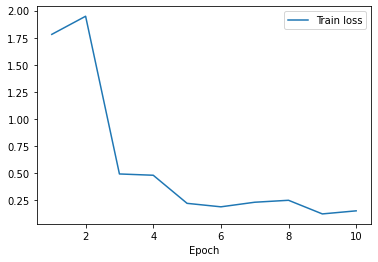

In [19]:
epoch_list = list(range(1, epochs+1))
epoch_losses = list(zip(epoch_list, loss))

loss_df = pd.DataFrame(epoch_losses, columns=["Epoch", "Train loss"])

lines = loss_df.plot.line(x="Epoch", y="Train loss")


## Test model

In [21]:
scores_dockq_train = test(model, device, test_generator_train_set, "train")
scores_dockq_test = test(model, device, test_generator_test_set, "test")

### Train complex 1 results

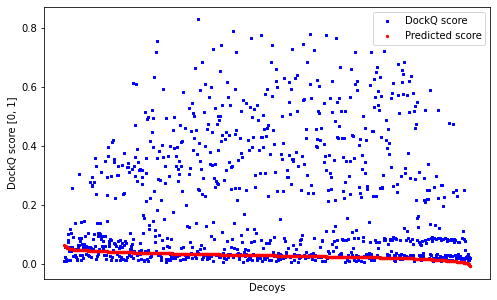

In [22]:
show_results("1bvn", scores_dockq_train)

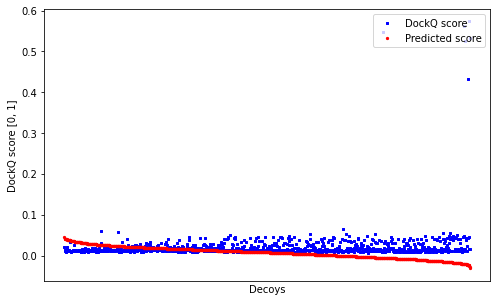

In [23]:
show_results("1f34", scores_dockq_train)

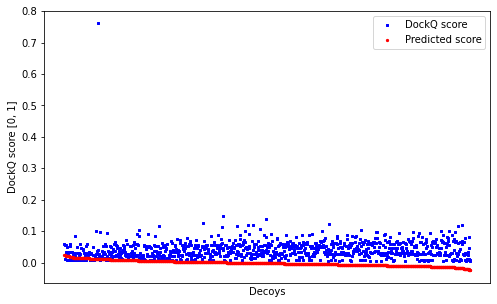

In [24]:
show_results("1pvh", scores_dockq_train)

### Test complex 1 results

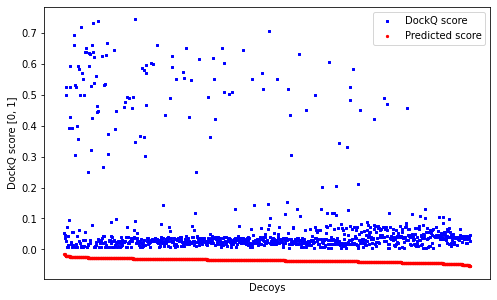

In [21]:
show_results("1b6c", scores_dockq_test)

### Test complex 2 results

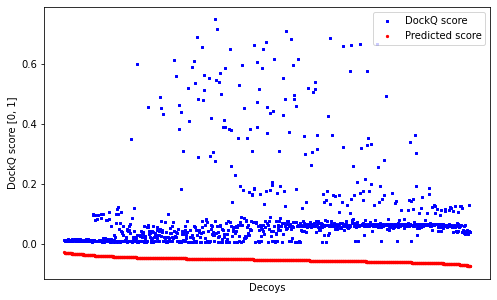

In [22]:
show_results("1e6e", scores_dockq)